# Benchmarking models at locating spatial expression of cell types with scRNA-seq reference and Visium spatial (mouse brain)

In [1]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
from plotnine import *
import matplotlib.pyplot as plt 
import matplotlib
import anndata
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True'
# /nfs/team283/vk7/software/miniconda3farm5/envs/cellpymc/bin/pip install git+https://github.com/vitkl/cell2location.git
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')
from tqdm.autonotebook import tqdm

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns
import itertools

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

/nfs/team205/vk7/software/miniconda/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


`THEANO_FLAGS='force_device=True'` forces the package to use GPU. Pay attention to error messages that might indicate theano failed to initalise the GPU.   
Do not forget to change `device=cuda4` to your available GPU id. Use `device=cuda` / `device=cuda0` if you have just one locally or if you are requesting one GPU via HPC cluster job.

### The purpose of the notebook is to benchmark several versions of the model using mouse brain data.

## Load other methods results

In [2]:
sc_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_data/mouse_visium_snrna/'
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/data/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/real_mg/'

In [3]:
adata = anndata.read(f'{sp_data_folder}synth_adata_real_mg_20210131.h5ad')
adata.uns['spatial'] = {'x': 'y'}

adata_snrna_raw = anndata.read(f'{sp_data_folder}training_5705STDY8058280_5705STDY8058281_20210131.h5ad')

import scipy
adata_snrna_raw.X = scipy.sparse.csr_matrix(adata_snrna_raw.X)
adata.X = scipy.sparse.csr_matrix(adata.X)

In [4]:
r_load = {'run_name': 'test_simplified2_alpha200_lr0.002_max_epochs40000_LocationModelLinearDependentWMultiExperimentLocationBackgroundNormLevelGeneAlphaPyroModel_test_data'}

fig_path=results_folder + '/pyro/' + r_load['run_name']+'/plots'

sp_data_file = results_folder + '/pyro/' +r_load['run_name']+'/sp.h5ad'
adata_vis_res = anndata.read(sp_data_file)
adata_snrna_raw.raw = adata_snrna_raw
adata_vis = adata.copy()
adata_vis.raw = adata_vis

In [9]:
from re import sub
cell_count = adata_vis_res.obs.loc[:, ['cell_abundances_' in i for i in adata_vis_res.obs.columns]]
cell_count.columns =  [sub('cell_abundances_', '', i) for i in cell_count.columns]
cell_count_columns = cell_count.columns
umi_count = adata_vis_res.obs.loc[:, ['UMI_count_' in i for i in adata_vis_res.obs.columns]]
umi_count.columns =  [sub('UMI_count_', '', i) for i in umi_count.columns]

spot_factors = adata_vis_res.obsm['q05_cell_abundance_w_sf']
spot_factors.columns = adata_vis_res.uns['mod']['factor_names']

# spot_factors_sd = adata_vis_res.obs[['sd_spot_factors' + i for i in cell_count_columns]]
# spot_factors_sd.columns =  [sub('sd_spot_factors', '', i) for i in spot_factors_sd.columns]

infer_cell_count = spot_factors[cell_count.columns]
#infer_cell_count = cells_per_factor[cell_count.columns]

# nUMI_factors = adata_vis_res.obs[['mean_nUMI_factors' + i for i in cell_count_columns]]
# nUMI_factors.columns =  [sub('mean_nUMI_factors', '', i) for i in nUMI_factors.columns]

In [10]:
cell_proportions = (cell_count.T / cell_count.sum(1)).T
cell_proportions.iloc[np.isnan(cell_proportions.values)] = 0
infer_cell_proportions = (infer_cell_count.T / infer_cell_count.sum(1)).T

cell2loc_df = infer_cell_proportions

In [11]:
stereo_path_1 = f'{results_folder}scvi_stereoscope/'
scvi_stereoscope = anndata.read(f'{stereo_path_1}sp_n_epochs30k.h5ad')

scvi_stereoscope = scvi_stereoscope.obsm['decomposition'].copy()
scvi_stereoscope = (scvi_stereoscope.T / scvi_stereoscope.sum(1)).T
scvi_stereoscope = scvi_stereoscope.loc[cell_count.index,:]
stereo_df = scvi_stereoscope[cell_count.columns]

In [12]:
# read cell proportions
nnls_path_1 = results_folder + 'autogenes_models/coef_nnls_seed.csv'
nnls_df = pd.read_csv(nnls_path_1, sep=',', index_col=0).T

# compute proportions per location
nnls_df = (nnls_df.T / nnls_df.sum(1)).T

adata_vis_plt = adata_vis.copy()
nnls_df = nnls_df.loc[nnls_df.index.isin(adata_vis_plt.obs_names)]
adata_vis_plt = adata_vis_plt[nnls_df.index,:]

adata_vis_plt.obs['imagecol'] = adata_vis_plt.obsm['X_spatial'][:,0]
adata_vis_plt.obs['imagerow'] = - adata_vis_plt.obsm['X_spatial'][:,1]
nnls_df = nnls_df[cell_count.columns]

Trying to set attribute `.obs` of view, copying.


In [13]:
# read cell proportions
RCTD_path_1 = results_folder + 'rctd/results_weights.csv'
RCTD_df = pd.read_csv(RCTD_path_1, sep=',', index_col='spot')

# compute proportions per location
RCTD_df_orig = RCTD_df.copy()
RCTD_df = (RCTD_df.T / RCTD_df.sum(1)).T

adata_vis_plt = adata_vis.copy()
RCTD_df = RCTD_df.loc[RCTD_df.index.isin(adata_vis_plt.obs_names)]
adata_vis_plt = adata_vis_plt[RCTD_df.index,:]

adata_vis_plt.obs['imagecol'] = adata_vis_plt.obsm['X_spatial'][:,0]
adata_vis_plt.obs['imagerow'] = - adata_vis_plt.obsm['X_spatial'][:,1]
RCTD_df = RCTD_df_orig[cell_count.columns]

Trying to set attribute `.obs` of view, copying.


In [14]:
# read cell proportions
seurat_path_1 = results_folder + 'seurat/results_pca.csv'
seurat_df = pd.read_csv(seurat_path_1, sep=',', index_col='spot')
seurat_df = seurat_df.drop(columns=['predicted.id', 'prediction.score.max', 'Unnamed: 0'])
from re import sub
seurat_df.columns = [sub('prediction.score.', '', i) for i in seurat_df.columns]

# compute proportions per location
seurat_df = (seurat_df.T / seurat_df.sum(1)).T

adata_vis_plt = adata_vis.copy()
seurat_df = seurat_df.loc[seurat_df.index.isin(adata_vis_plt.obs_names)]
adata_vis_plt = adata_vis_plt[seurat_df.index,:]

adata_vis_plt.obs['imagecol'] = adata_vis_plt.obsm['X_spatial'][:,0]
adata_vis_plt.obs['imagerow'] = - adata_vis_plt.obsm['X_spatial'][:,1]
seurat_df = seurat_df[cell_count.columns]

Trying to set attribute `.obs` of view, copying.


In [15]:
# read cell proportions
spotlight_path_1 = results_folder + 'SPOTlight/results_hvg5k.csv'
spotlight_df = pd.read_csv(spotlight_path_1, sep=',', index_col='rn')
spotlight_df = spotlight_df.drop(columns=['res_ss'])

from re import sub

seu_index = [sub(' ', '.',i) for i in cell_proportions.columns]
seu_index = [sub('/', '.',i) for i in seu_index]
seu_index = [sub('-', '.',i) for i in seu_index]
seu_index = [sub('_', '.',i) for i in seu_index]

spotlight_df = spotlight_df[seu_index]
spotlight_df.columns = cell_proportions.columns

# compute proportions per location (already proportions)
#spotlight_df = (spotlight_df.T / spotlight_df.sum(1)).T

adata_vis_plt = adata_vis.copy()
spotlight_df = spotlight_df.loc[spotlight_df.index.isin(adata_vis_plt.obs_names)]
adata_vis_plt = adata_vis_plt[spotlight_df.index,:]

adata_vis_plt.obs['imagecol'] = adata_vis_plt.obsm['X_spatial'][:,0]
adata_vis_plt.obs['imagerow'] = - adata_vis_plt.obsm['X_spatial'][:,1]
spotlight_df = spotlight_df[cell_count.columns]

Trying to set attribute `.obs` of view, copying.


In [16]:
cell_prop_dfs = [cell2loc_df, stereo_df, seurat_df, RCTD_df, spotlight_df, nnls_df]
method_names = ['Cell2location', 'Stereoscope', 'Seurat', 'RCTD', 'SPOTlight', 'NNLS']

In [19]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

rows = []

for cell_prop_df, method_name in zip(cell_prop_dfs, method_names):
    pos_cell_count = cell_count.values > 0.1
    predictor = cell_prop_df.values + np.random.gamma(20, 1e-12, cell_prop_df.shape)

    mode = 'macro'
    PR_macro = average_precision_score(pos_cell_count, predictor, average=mode)

    mode = 'micro'
    PR_micro = average_precision_score(pos_cell_count, predictor, average=mode)

    relative_r = np.corrcoef(cell_proportions.values.flatten(), 
                                           cell_prop_df.values.flatten())[0,1]
    
    rows.append((method_name, PR_macro, PR_micro, relative_r))
    
other_methods_df = pd.DataFrame(rows, columns=['method_name', 'PR_score_macro', 'PR_score_micro', 'relative_r'])

In [20]:
other_methods_df

,method_name,PR_score_macro,PR_score_micro,relative_r
0,Cell2location,0.661248,0.642961,0.691845
1,Stereoscope,0.558379,0.501700,0.444342
2,Seurat,0.480033,0.424087,0.391150
3,RCTD,0.553817,0.509256,0.123174
4,SPOTlight,0.541767,0.431635,0.003781
5,NNLS,0.337959,0.314303,-0.049561


In [21]:
sc_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_data/mouse_visium_snrna/'
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/data/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/real_mg/pyro/hyperparameters/'

In [22]:
folder_names = [i for i in os.listdir(results_folder) if 'test' in i]
res = pd.concat([pd.read_csv(f'{results_folder}/param_tables/table_{i}.csv') for i in range(6)])

In [23]:
res.index = res['names']

### Read and compute R^2 and PR score

In [24]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

for i, f in tqdm(enumerate(folder_names[:])):
    
    sp_data_file = f'{results_folder}/{f}/sp.h5ad'
    adata_vis_res = anndata.read(sp_data_file)
    
    from re import sub
    cell_count = adata_vis_res.obs.loc[:, ['cell_abundances_' in i for i in adata_vis_res.obs.columns]]
    cell_count.columns =  [sub('cell_abundances_', '', i) for i in cell_count.columns]
    cell_count_columns = cell_count.columns
    umi_count = adata_vis_res.obs.loc[:, ['UMI_count_' in i for i in adata_vis_res.obs.columns]]
    umi_count.columns =  [sub('UMI_count_', '', i) for i in umi_count.columns]

    spot_factors = adata_vis_res.obsm['q05_cell_abundance_w_sf']
    spot_factors.columns = adata_vis_res.uns['mod']['factor_names']
#     nUMI_factors = adata_vis_res.obs[['mean_nUMI_factors' + i for i in cell_count_columns]]
#     nUMI_factors.columns =  [sub('mean_nUMI_factors', '', i) for i in nUMI_factors.columns]
    
    infer_cell_count = spot_factors[cell_count.columns]
#     infer_nUMI_count = nUMI_factors[cell_count.columns]
    
    cell_proportions = (cell_count.T / cell_count.sum(1)).T
    cell_proportions.iloc[np.isnan(cell_proportions.values)] = 0
    infer_cell_proportions = (infer_cell_count.T / infer_cell_count.sum(1)).T
    
    # compute R^2
    res.loc[f, 'absolute_r'] = np.corrcoef(cell_count.values.flatten(), 
                                           infer_cell_count.values.flatten())[0,1]
    res.loc[f, 'relative_r'] = np.corrcoef(cell_proportions.values.flatten(), 
                                           infer_cell_proportions.values.flatten())[0,1]
#     res.loc[f, 'mRNA_r'] = np.corrcoef(umi_count.values.flatten(), 
#                                        nUMI_factors.values.flatten())[0,1]
    pos_cell_count = cell_count.values > 0.1
    predictor = infer_cell_proportions.values + np.random.gamma(20, 1e-12, 
                                                                infer_cell_proportions.shape)
    # For each cell type
    mode = 'macro'
    res.loc[f, f'PR_score_{mode}'] = average_precision_score(pos_cell_count, predictor, average=mode)
    #res.loc[f, f'ROC_score_{mode}'] = roc_auc_score(pos_cell_count, predictor, average=mode)
    mode = 'micro'
    res.loc[f, f'PR_score_{mode}'] = average_precision_score(pos_cell_count, predictor, average=mode)
    #res.loc[f, f'ROC_score_{mode}'] = roc_auc_score(pos_cell_count, predictor, average=mode)
    
    # compute PR score
    for c in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.5]:
        pos_cell_count = cell_count.values > c
        predictor = infer_cell_proportions.values + np.random.gamma(20, 1e-12, 
                                                                    infer_cell_proportions.shape)
        # For each cell type
        mode = 'macro'
        res.loc[f, f'PR_score_{mode}_density{c}'] = average_precision_score(pos_cell_count, predictor, average=mode)
        #res.loc[f, f'ROC_score_{mode}'] = roc_auc_score(pos_cell_count, predictor, average=mode)
        mode = 'micro'
        res.loc[f, f'PR_score_{mode}_density{c}'] = average_precision_score(pos_cell_count, predictor, average=mode)
        #res.loc[f, f'ROC_score_{mode}'] = roc_auc_score(pos_cell_count, predictor, average=mode)
    
res

0it [00:00, ?it/s]

,detection_alpha,N_cells_per_location,A_factors_per_location,B_groups_per_location,lr,max_epochs,names,absolute_r,relative_r,PR_score_macro,...,PR_score_macro_density0.8,PR_score_micro_density0.8,PR_score_macro_density0.9,PR_score_micro_density0.9,PR_score_macro_density1.0,PR_score_micro_density1.0,PR_score_macro_density1.2,PR_score_micro_density1.2,PR_score_macro_density1.5,PR_score_micro_density1.5
names,,,,,,,,,,,,,,,,,,,,,
test_hyperparameters_v3_adam_100.0_500.0_16.0_1.0_test_data,100.0,500.0,16.0,1.0,0.002,40000,test_hyperparameters_v3_adam_100.0_500.0_16.0_...,0.392114,0.341448,0.483068,...,0.292223,0.232965,NaN,0.219405,NaN,0.209028,NaN,0.189999,NaN,0.171646
test_hyperparameters_v3_adam_1.0_3.0_500.0_1.0_test_data,1.0,3.0,500.0,1.0,0.002,40000,test_hyperparameters_v3_adam_1.0_3.0_500.0_1.0...,0.701697,0.676626,0.624480,...,0.459877,0.522245,NaN,0.518568,NaN,0.513654,NaN,0.498663,NaN,0.480874
test_hyperparameters_v3_adam_50.0_3.0_1000.0_150.0_test_data,50.0,3.0,1000.0,150.0,0.002,40000,test_hyperparameters_v3_adam_50.0_3.0_1000.0_1...,0.607757,0.557093,0.628904,...,0.463077,0.406143,NaN,0.392279,NaN,0.379867,NaN,0.353938,NaN,0.324695
test_hyperparameters_v3_adam_10.0_500.0_1.0_1000.0_test_data,10.0,500.0,1.0,1000.0,0.002,40000,test_hyperparameters_v3_adam_10.0_500.0_1.0_10...,0.306069,0.282568,0.452803,...,0.248653,0.203104,NaN,0.187741,NaN,0.175978,NaN,0.156691,NaN,0.137866
test_hyperparameters_v3_adam_1000.0_150.0_40.0_16.0_test_data,1000.0,150.0,40.0,16.0,0.002,40000,test_hyperparameters_v3_adam_1000.0_150.0_40.0...,0.598533,0.600651,0.573894,...,0.393822,0.426757,NaN,0.424178,NaN,0.420365,NaN,0.410010,NaN,0.396206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
test_hyperparameters_v3_adam_1.0_40.0_10.0_40.0_test_data,1.0,40.0,10.0,40.0,0.002,40000,test_hyperparameters_v3_adam_1.0_40.0_10.0_40....,0.666955,0.668083,0.616944,...,0.456646,0.504729,NaN,0.510251,NaN,0.513321,NaN,0.515306,NaN,0.515721
test_hyperparameters_v3_adam_20.0_10.0_5.0_500.0_test_data,20.0,10.0,5.0,500.0,0.002,40000,test_hyperparameters_v3_adam_20.0_10.0_5.0_500...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
test_hyperparameters_v3_adam_100.0_500.0_500.0_80.0_test_data,100.0,500.0,500.0,80.0,0.002,40000,test_hyperparameters_v3_adam_100.0_500.0_500.0...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Look at stability of inference for relative values

In [25]:
fig_path=f'{results_folder}hyperparameters_v2/plots'
fig_path

'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/real_mg/pyro/hyperparameters/hyperparameters_v2/plots'

In [26]:
res.head()

,detection_alpha,N_cells_per_location,A_factors_per_location,B_groups_per_location,lr,max_epochs,names,absolute_r,relative_r,PR_score_macro,...,PR_score_macro_density0.8,PR_score_micro_density0.8,PR_score_macro_density0.9,PR_score_micro_density0.9,PR_score_macro_density1.0,PR_score_micro_density1.0,PR_score_macro_density1.2,PR_score_micro_density1.2,PR_score_macro_density1.5,PR_score_micro_density1.5
names,,,,,,,,,,,,,,,,,,,,,
test_hyperparameters_v3_adam_100.0_500.0_16.0_1.0_test_data,100.0,500.0,16.0,1.0,0.002,40000,test_hyperparameters_v3_adam_100.0_500.0_16.0_...,0.392114,0.341448,0.483068,...,0.292223,0.232965,NaN,0.219405,NaN,0.209028,NaN,0.189999,NaN,0.171646
test_hyperparameters_v3_adam_1.0_3.0_500.0_1.0_test_data,1.0,3.0,500.0,1.0,0.002,40000,test_hyperparameters_v3_adam_1.0_3.0_500.0_1.0...,0.701697,0.676626,0.624480,...,0.459877,0.522245,NaN,0.518568,NaN,0.513654,NaN,0.498663,NaN,0.480874
test_hyperparameters_v3_adam_50.0_3.0_1000.0_150.0_test_data,50.0,3.0,1000.0,150.0,0.002,40000,test_hyperparameters_v3_adam_50.0_3.0_1000.0_1...,0.607757,0.557093,0.628904,...,0.463077,0.406143,NaN,0.392279,NaN,0.379867,NaN,0.353938,NaN,0.324695
test_hyperparameters_v3_adam_10.0_500.0_1.0_1000.0_test_data,10.0,500.0,1.0,1000.0,0.002,40000,test_hyperparameters_v3_adam_10.0_500.0_1.0_10...,0.306069,0.282568,0.452803,...,0.248653,0.203104,NaN,0.187741,NaN,0.175978,NaN,0.156691,NaN,0.137866
test_hyperparameters_v3_adam_1000.0_150.0_40.0_16.0_test_data,1000.0,150.0,40.0,16.0,0.002,40000,test_hyperparameters_v3_adam_1000.0_150.0_40.0...,0.598533,0.600651,0.573894,...,0.393822,0.426757,NaN,0.424178,NaN,0.420365,NaN,0.410010,NaN,0.396206


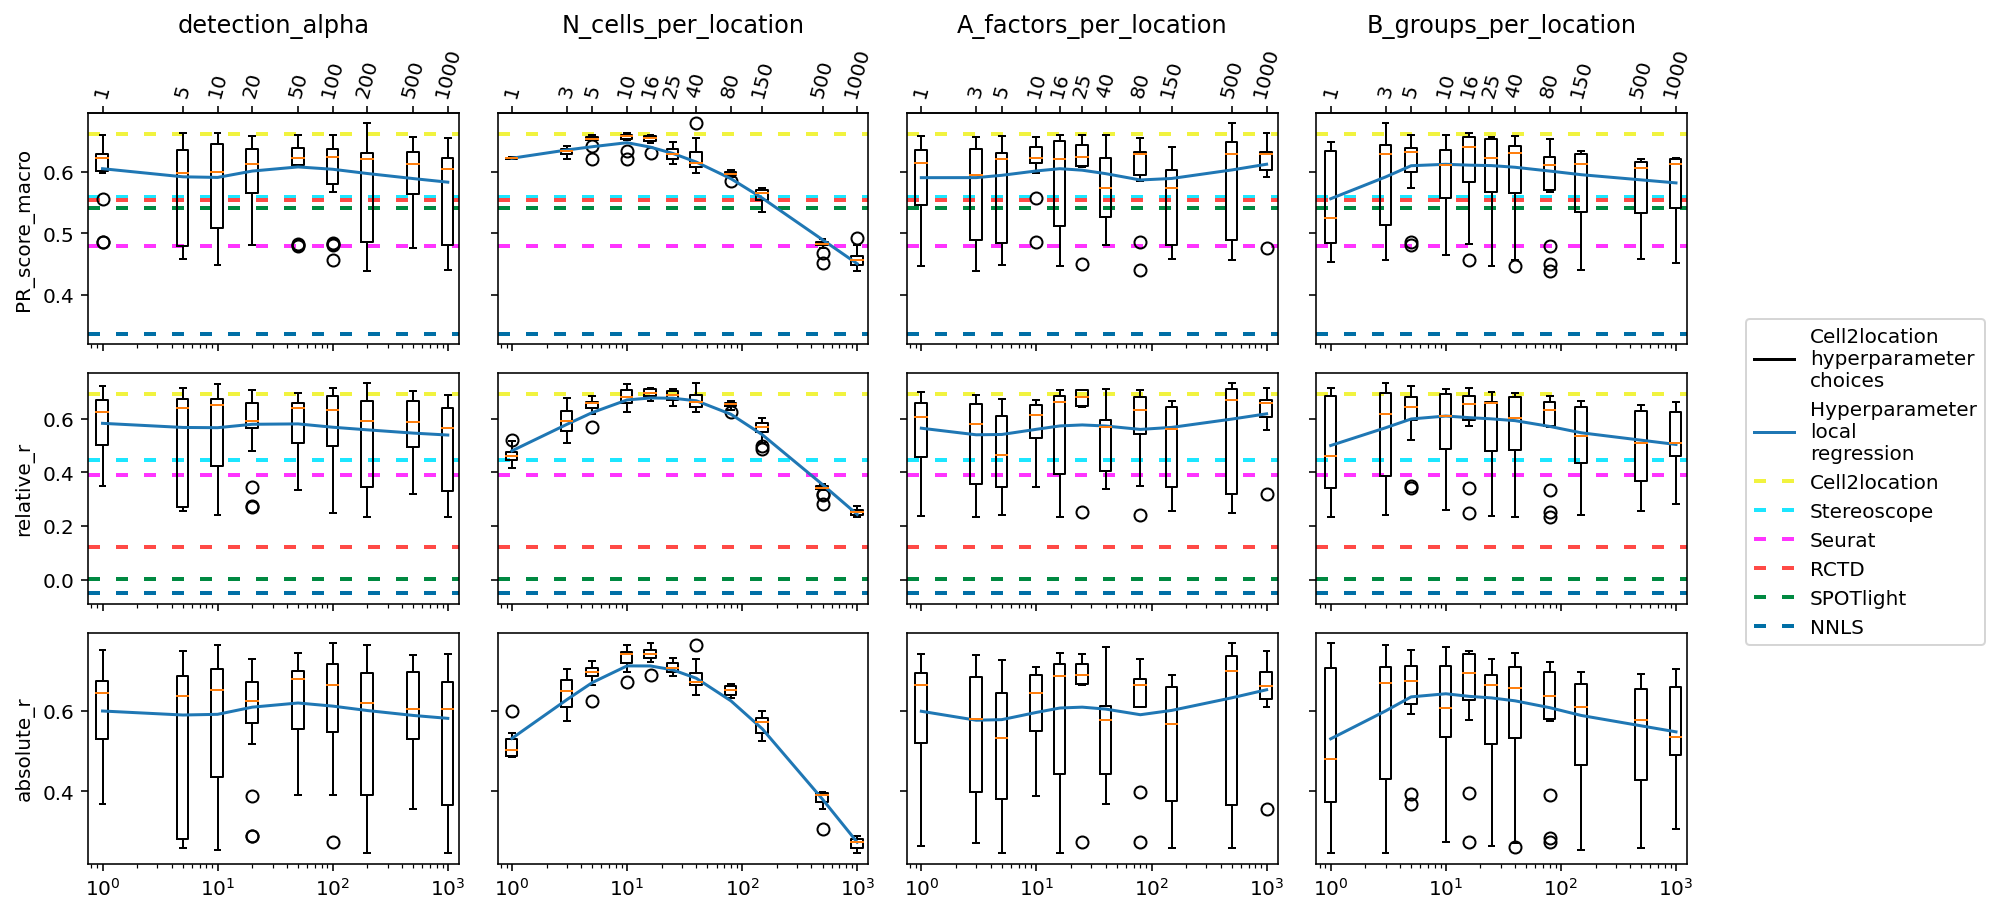

In [31]:
import statsmodels.api as sm


fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(12, 6.5), sharex=True, sharey='row')

param_names = ['detection_alpha', 'N_cells_per_location', 'A_factors_per_location', 'B_groups_per_location']
score_names = ['PR_score_macro', 'relative_r', 'absolute_r']

res2 = res.iloc[:, :25].dropna()

for n_score, score_name in enumerate(score_names):
    for n_param, param_name in enumerate(param_names):
        ax = axs[n_score, n_param]
#         ax.scatter(res2[param_name].values.flatten(), res2[score_name].values.flatten())
        gb = res2[[param_name, score_name]].groupby(param_name)
        w = 0.1
        width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)
        pos = [i[0] for i in gb]
        values = [i[1][score_name].values for i in gb]
        ax.boxplot(values, positions=pos, widths=width(pos,w))
        ax.plot([], [], color='k', label='Cell2location\nhyperparameter\nchoices')
        lowess_sm = sm.nonparametric.lowess
        yest_sm = lowess_sm(res2[score_name].values.flatten() ,np.log10(res2[param_name].values.flatten()), 
                            frac=1/2, it=5, return_sorted=True)
        ax.plot(10**yest_sm[:, 0], yest_sm[:, 1], color='C0', label='Hyperparameter\nlocal\nregression')
        ax.set_xscale('log')
        if ax.is_first_row():
            ax.set_title(param_name)
            secax_x = ax.secondary_xaxis('top', functions=(lambda x: x, lambda x: x))
            secax_x.set_xticks(pos)
            secax_x.set_xticklabels(np.array(pos).astype(int), rotation=75)
            secax_x.minorticks_off()
        if ax.is_first_col():
            ax.set_ylabel(score_name)
        
        x_min, x_max = ax.set_xlim(0.75, 1250)
        
        if score_name in other_methods_df.columns:
            for n, name, score in other_methods_df.loc[:, ['method_name', score_name]].itertuples():
                color = sc.pl.palettes.default_102[n]
                if n == 0:
                    color = 'xkcd:off yellow'
                ax.hlines(score, 0.75, 1250, colors=[color], 
                          linewidth=2, label=name, linestyle=(0, (3, 4)))
        
plt.figlegend(*axs[0,0].get_legend_handles_labels(), bbox_to_anchor=(1.01,0.475), loc="center left")
        
plt.tight_layout()

plt.savefig('stability_local_regression_synthetic.pdf', bbox_inches='tight')